# Introduction
#### she changlue
20th April 2017

This project is construct to handle documents topic classification.
I use self designed algorithm to efficiently embedding the documents' topic vector and tokens' topic vector.It is emperiacally proved that this algorithm can classify the topic of different documents and tokens in a speed way.

this notebook will process as follow:
1. load library and raw corpus data
2. cut the corpus in to a list format
3. encode the tokens and corpus
4. construct model and train
5. use kmeans to do tokens' and docs' cluster 
6. use T-SNE to visualization
7. save the outcomes

### 1)   load library and raw corpus data

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
from random import shuffle
from sklearn.cluster import KMeans#cluster

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import jieba.posseg as pseg # cut the documents with token and tags
import jieba
import tensorflow as tf

from sklearn.manifold import TSNE#cluster



In [2]:
jieba.load_userdict('corpus/custormTokens.txt')  
rawdata = pd.read_csv('corpus/opr_rem.csv', header=0,nrows=3000)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\changlue.she\AppData\Local\Temp\jieba.cache
Loading model cost 0.969 seconds.
Prefix dict has been built succesfully.


#### corpus briefing

In [3]:
rawdata.head()

,opr_rem
0,今天下午5点472
1,\t告知客户电话15226088432
2,说是叔侄关系 转告
3,客户承诺今天下午五点存入184
4,已提醒征信影响。已告知从今天凌晨开始又会多增加75元的滞纳金。客户敷衍明天去解决


In [4]:
rawdata.shape

(3000, 1)

In [5]:
rawdata.describe()

,opr_rem
count,3000
unique,3000
top,一直说不知道，然后挂断
freq,1


### 2) cut the corpus in to a list format

In [6]:
tokenCorpus  = []#corpus list of cutted tokens
rawSentences = []#raw text 
#documents    = list(rawdata[rawdata['消息目标']=='机器人']['消息内容'])#text which is send by custormers
documents    = list(rawdata['opr_rem'])#text which is send by custormers

In [7]:
# cstruct the corpus
for sentence in documents:
    if len(str(sentence))>4:
        sentence = sentence.replace('\t','')
        tokens = []    
        for pair in pseg.lcut(sentence):
            if pair.flag in ['t','n','ns','vs','nv','v']:
                tokens.append(pair.word)
            elif pair.flag=='m':
                if len(str(pair.word))==11:
                    tokens.append('NUMB')
                else:
                    tokens.append('MON')   
        if len(tokens)>1:
            tokenCorpus.append(tokens)
            rawSentences.append(sentence)

In [8]:
tokenCorpus[:3]

[['MON', 'MON', 'MON'],
 ['告知', '客户', '电话', 'NUMB'],
 ['说', '是', '叔侄', '关系', '转告']]

In [9]:
rawSentences[:5]

['今天下午5点472',
 '告知客户电话15226088432',
 '说是叔侄关系  转告 ',
 '客户承诺今天下午五点存入184',
 '已提醒征信影响。已告知从今天凌晨开始又会多增加75元的滞纳金。客户敷衍明天去解决']

### 3) encode the tokens and corpus

In [10]:
HP_miniTokenFreq = 30 #minimal tokens frequency
tokenCount = dict()  #token count
token2code = dict()  #token to code
code2token = ['IFRQ'] #code to token
code       = 1       #code

##### transfer token into codes

In [11]:
#get token frequency
for tokens in tokenCorpus:
    for token in tokens:
        tokenCount.setdefault(token,0)
        tokenCount[token]+=1  
#encode those tokens which have minumal frequency
for token in tokenCount:
    if tokenCount[token] > HP_miniTokenFreq:       
        token2code[token] = code
        code += 1
        code2token.append(token)
    else:
        token2code[token] = 0
#transfer the raw token corpus into encoded corpus
codeCorpus = []
for tokens in tokenCorpus:          
    codeCorpus.append([token2code[token]for token in tokens])

### 4) construct model and train

In [12]:
HP_topicNums = 8
documNums = len(codeCorpus)
tokenNums = len(code2token)
print("the training documents num:",documNums)
print("the training tokens    num:",tokenNums)

the training documents num: 2929
the training tokens    num: 76


##### dense list to sparse numpy

In [13]:
tokenDocMat = np.zeros(shape=(documNums,tokenNums),dtype=np.float32)
for docIdx in range(documNums):
    tokenDocMat[docIdx][codeCorpus[docIdx]]=1
docTokenNum = tokenDocMat.sum(axis=1).reshape((-1,1))   

##### get doc index and shuffle it

In [14]:
docIndxSpan = np.array(range(documNums),dtype=np.int32)
shuffle(docIndxSpan)

##### construct the graph

In [15]:
#embedding initial
docum2topicEmbed  = tf.Variable(tf.random_uniform([documNums,HP_topicNums], -1.0, 1.0),name='docEmbed')
token2topicWeight = tf.Variable(tf.random_uniform([HP_topicNums,tokenNums], -1.0, 1.0),name='tokenEmbed')
multiplierEmbed   = tf.constant(docTokenNum,dtype=tf.float32)

In [16]:
#placeholder
document_idx   = tf.placeholder(tf.int32, shape=[None])
document_embed = tf.nn.embedding_lookup(docum2topicEmbed,document_idx) 
multiplier     = tf.nn.embedding_lookup(multiplierEmbed ,document_idx) 
tokensInDoc    = tf.placeholder(tf.float32,shape=[None,tokenNums])

In [17]:
#forward 
with tf.name_scope("TM"):
    documentembed_Sfmx     = tf.nn.softmax(document_embed)
    token2topicWeight_Sfmx = tf.nn.softmax(token2topicWeight,dim=0)
    tokensInDoc_pred       = tf.nn.softmax(tf.matmul(documentembed_Sfmx,token2topicWeight_Sfmx))*multiplier                           

In [18]:
# use least squre loss to train model
with tf.name_scope("loss"):   
    loss = tf.reduce_mean(tf.square(tokensInDoc - tokensInDoc_pred))

In [19]:
learning_rate = 0.1
with tf.name_scope("train"):    
    optimizer   = tf.train.AdamOptimizer(learning_rate)
    #set train operation
    training_op = optimizer.minimize(loss)
    #set predict operation
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="docEmbed")
    predict_op = optimizer.minimize(loss, var_list=train_vars)

In [20]:
#initial and save
init = tf.global_variables_initializer()
saver = tf.train.Saver()

#### training the tensorflow graph

In [33]:
#hyperparameters
n_epochs   = 100
printLoop  = n_epochs/10
traningNum = 10000
batchNums  = documNums//traningNum+1
with tf.Session() as sess:    
    init.run()
    for epoch in range(n_epochs):
        #training
        trainIdx = docIndxSpan[:traningNum]
        top,train_loss =sess.run([training_op,loss], feed_dict={document_idx : trainIdx,                                                          
                                                                tokensInDoc  : tokenDocMat[trainIdx]})  
        if epoch%printLoop==0:
            print(train_loss)
    save_path = saver.save(sess,"tfsave/topic_model.ckpt")
    print("finished training,now begin predict")
    for epoch in range(n_epochs//10):
        for batch in range(batchNums):
        #training
            trainIdx = docIndxSpan[batch*traningNum:(batch+1)*traningNum]
            top,train_loss =sess.run([predict_op,loss], feed_dict={document_idx : trainIdx,                                                          
                                                                   tokensInDoc  : tokenDocMat[trainIdx]})  
        if epoch%printLoop==0:
            print(train_loss)
    # get embedding
    documMat = documentembed_Sfmx.eval(feed_dict={document_idx : docIndxSpan})
    tokenMat = token2topicWeight_Sfmx.eval()

0.0548076
0.0547711
0.054604
0.0540513
0.0531102
0.0522185
0.0516673
0.0513571
0.051149
0.0510297
finished training,now begin predict
0.0509515


In [34]:
documMat.sum(axis=1)[:5],tokenMat.sum(axis=0)[:5]

(array([ 1.        ,  0.99999994,  0.99999982,  1.        ,  0.99999994], dtype=float32),
 array([ 0.99999994,  0.99999982,  1.        ,  0.99999988,  0.99999994], dtype=float32))

#### show the rough topic

In [35]:
topK = 10
outDF = []
keyWords = []
keySentences = []
for idx in range(HP_topicNums):    
    ords = np.argsort(-tokenMat[idx])[:topK]
    tmp = ['主题'+str(idx+1)]
    tmp += [code2token[i]for i in ords]
    keyWords+=tmp
    ords = np.argsort(-documMat.T[idx])[:topK]
    tmp = ['------------------------------']
    tmp +=[rawSentences[i]for i in ords]
    keySentences+=tmp
outDF = [keyWords,keySentences] 
outDF = pd.DataFrame(outDF).T
outDF.to_csv('save/topic.csv',encoding='gbk',index=False)

In [36]:
outDF.head(100)

,0,1
0,主题1,------------------------------
1,说,本人接听，，，承诺明天下午四点前 还款353
2,告知,告知征信影响，客户答应今天下午4点之前处理还款，金额：217
3,没有,一女接电 不在家
4,去,一直说我们扣过他的款了 说他的工商卡上的钱已经被扣了 这边跟他核实是中信银行 他明天去...
5,会,已划扣201
6,让,爷爷接听，，说妈妈采桑叶去了，说客户有好几个月没见了，打电话打不通，
7,要,卡有钱，已存 362
8,核实,客户本人承诺今天下午四点前存入 681 元
9,客服,卡里有钱 430元 系统处理中


### 5)  use kmeans to do tokens' and docs' cluster

In [37]:
tokenMat_KM = KMeans(n_clusters=HP_topicNums, random_state=0).fit(tokenMat.T)
documMat_KM = KMeans(n_clusters=HP_topicNums, random_state=0).fit(documMat)

In [38]:
tokenMat_Label = tokenMat_KM.labels_
documMat_Label = documMat_KM.labels_

### 6)  use T-SNE to visualization

In [39]:
tokenMat_tsne_embed = TSNE(random_state=1).fit_transform(tokenMat.T)  
documMat_tsne_embed = TSNE(random_state=1).fit_transform(documMat)  

##### the visualization of word embeddings

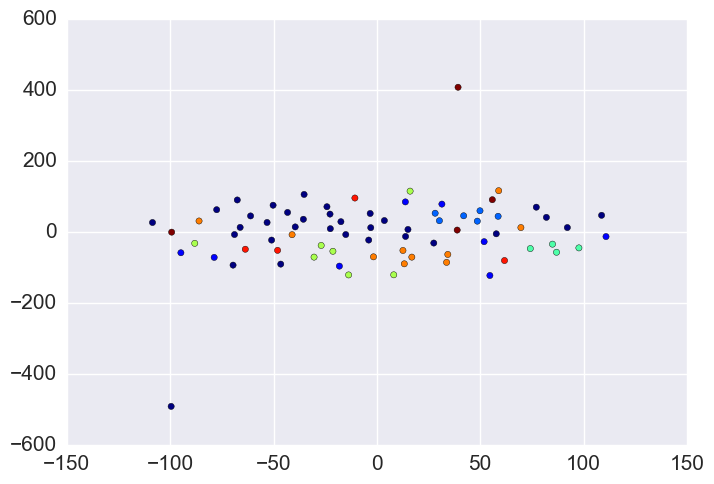

In [40]:
plt.scatter(tokenMat_tsne_embed[:,0],tokenMat_tsne_embed[:,1],c=tokenMat_Label, cmap=plt.cm.get_cmap("jet", 10))

##### the visualization of document embeddings

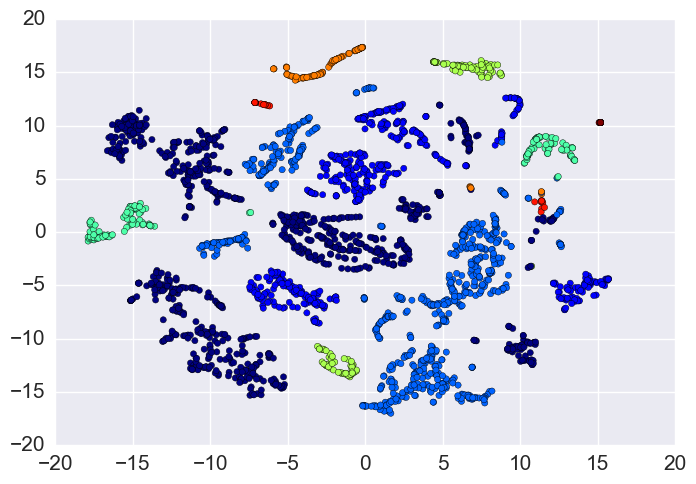

In [41]:
plt.scatter(documMat_tsne_embed[:,0],documMat_tsne_embed[:,1],c=documMat_Label, cmap=plt.cm.get_cmap("jet", 10))

### 7)  save the outcomes

In [42]:
outDF= pd.DataFrame()
outDF['text']=rawSentences
outDF['label']=documMat_Label

In [43]:
outDF.head(100)

,text,label
0,今天下午5点472,0
1,告知客户电话15226088432,2
2,说是叔侄关系 转告,0
3,客户承诺今天下午五点存入184,1
4,已提醒征信影响。已告知从今天凌晨开始又会多增加75元的滞纳金。客户敷衍明天去解决,1
5,今天晚上4点前存入721,0
6,13606375572销售来电扣款,2
7,告知征信影响 明天下午5点前存入金额791,1
8,只是人生，转告,2
9,来电咨询提现告知打客服,0


In [32]:
outDF.to_csv('save/docLabel.csv',encoding='gbk',index=False)